# Final Project - Karthik Muthukumar

This project aims to provide the user with deeper insight on best fit models for fitting a curve given a dataset. The example I will seek to model and fit is the frequency of galaxies given a certain distance. How I aim to implement this is by importing data published by the Sloan Digital Sky Survey and using different fitting methods to best fit the data. I will try my best to walk through each step of the process.

First I want to import the data from the SDSS data base and download it as a CSV file. How I went about doing this was first accessing the [SDSS Website](https://cas.sdss.org/dr18) and running the SQL search query. In specific what I searched for was just for the redshift value $z$ and for the ObjId (which identifies the galaxy if needed). This corresponds to:
<small>
```sql
SELECT TOP 500
    p.objID AS GalaxyID,
    s.z AS Redshift
FROM PhotoObj AS p
JOIN SpecObj AS s ON s.bestObjID = p.objID
WHERE s.z > 0
```
Line 1 corresponds to 500 rows being returned. Line 2 and 3 specify to take the objID as the galaxy ID and s.z as the Redshift value. Line 4 corresponds to take the values from the PhotoObj table.
Line 5 corresponds to joining the tables and line 6 corresponds to to taking only the positive Redshift values since we are only looking at the recession velocity of galaxies.
</small>

After this I selected to option to download it as a CSV and hit run, then I uploaded it to my project folder. Through this I am now able to access the table data through the use of pandas.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



# Load the data from the CSV file

data = pd.read_csv('sdss_galaxy_data.csv', skiprows=1) #reads the data from the CSV file (the CSV file contains the header called #table 1 in the first row so it skips the first row)

data.head(21) #returns the first 20 rows as an example

,GalaxyID,Redshift
0,1237645879551000764,0.399661
1,1237645879551066262,0.032125
2,1237645879562928144,0.312048
3,1237645879562928258,0.200468
4,1237645879562928805,0.752730
5,1237645879573873373,0.504868
6,1237645879577477252,0.110611
7,1237645879577739681,0.293778
8,1237645879577936138,0.074298
9,1237645879578460255,0.121315


We see above the values of the table from the CSV file. Now we can try to calculate for the distance from Earth and the recession velocities for each. How I will approach doing this is taking each value of the Redshift and using the various formulas to calculate for the distance and recession velocity into a new column respectively. To start, the formulas I will be using are $$\text{(Distance) } d = \frac{z \cdot c}{H_0}$$ where $H_0$ is the Hubble constant which ranges from 67 (km/s)/Mpc to about 74 (km/s)/Mpc depending on the study, here we will assume that it is about 67 (km/s)/Mpc given latest research on the topic. The research paper that supports this is: [Measuring the Hubble constant with kilonovae using the expanding photosphere method](https://www.aanda.org/articles/aa/full_html/2023/10/aa46306-23/aa46306-23.html) which will also be cited below.

In [36]:
data = pd.read_csv('sdss_galaxy_data_updated.csv', skiprows=1)

H0 = 67                                                   #Hubble constant (km/s)/Mpc 
c = 299792                                                #Speed of light in km/s (not m/s)

data['Distance (Mpc)'] = data['Redshift'] * c / H0        #Creates a new column called distance and calculates the distance by using v = z * c

data.head(21)                                             #Displays the tables first 20 rows




,GalaxyID,Redshift,Distance (Mpc)
0,1237645879551000764,0.399661,1788.285680
1,1237645879551066262,0.032125,143.741494
2,1237645879562928144,0.312048,1396.262000
3,1237645879562928258,0.200468,896.996457
4,1237645879562928805,0.752730,3368.098240
5,1237645879573873373,0.504868,2259.037423
6,1237645879577477252,0.110611,494.930192
7,1237645879577739681,0.293778,1314.514091
8,1237645879577936138,0.074298,332.445076
9,1237645879578460255,0.121315,542.825320


Next I am going to plot the distances vs the frequency of galaxies given at the certain distances using a 1D graph

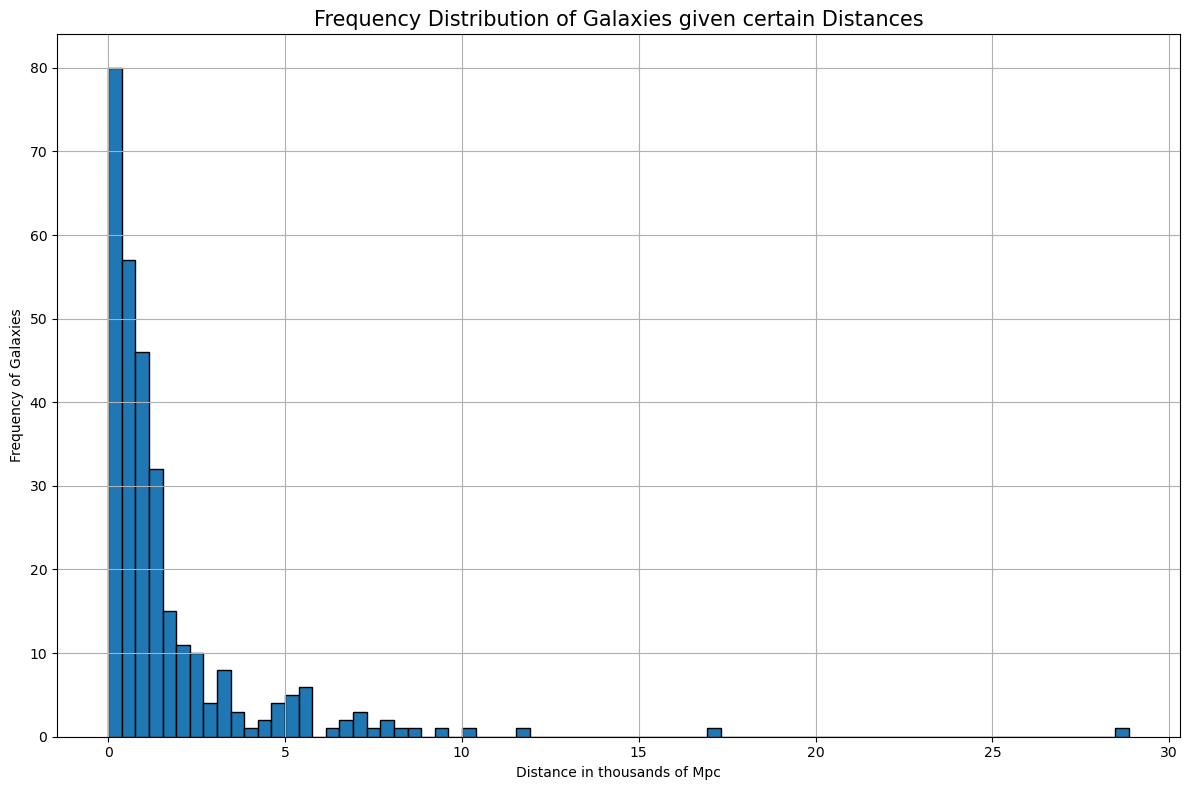

In [37]:
data['Distance (Mpc)'] = data['Distance (Mpc)']/1000                                    #Rescales data to manage overflow errors I was encountering later on

plt.figure(figsize = (12,8))                                                            #This line controls the size of the graph that is shown right below this cell
plt.hist(data['Distance (Mpc)'], bins = 75, edgecolor = 'black')                        #This line creates a histogram of the frequency of galaxies given certain distances 
                                                                                        #Each bin consists of a range of distance values, here it is how many galaxies there are every 385 megaparsecs
                                                                                        #5000/13 = 384.61


#The next few lines add details to the plot like a grid and labels
plt.title("Frequency Distribution of Galaxies given certain Distances", fontsize = 15)  
plt.xlabel("Distance in thousands of Mpc")
plt.ylabel("Frequency of Galaxies")
plt.grid(True)
plt.tight_layout()
plt.show()



I will now try to nonlinear least squares fit the curve by using the Gauss Newton Method. To start off we select some model function we believe will best fit our data. Judging by the data I have plotted we can see that it closely resembles an oscillating exponential decay function of the form $y = a\cdot e^{-bx}\cdot \sin{(cx+d)}$. The premise of this method is to find the best values to represent the coefficients $a$, $b$, $c$, and $d$ for the data to fit. We also need to be able to get specific x values corresponding to the y (frequency) values for the x and y arrays. To do that we can take the center point of each bin which will correspond to the frequency of that bin.

In [38]:
frequencies, edges = np.histogram(data['Distance (Mpc)'], bins = 75) #Extracts the frequency values and edge values

center_points = (edges[:-1]+edges[1:])/2    #Since the bin edges are going from 0-385 and then 385 to 770 etc, what this does is take the left edge of each bin and adds it to the right edge of each bin then 
                                            #finding the midpoint. In specific it takes an array of all bin edge values except the last and adds it to array of all bin edge values except the first 
                                            #and divides by 2. For example, the first midpoint is calculated as (first index)+(second index)/2 or [0+385]/2 which is approximately 195. Second midpoint is
                                            #(second index)+(third index)/2 or [385+770]/2 = 577.5 or approximately 195+385.

#Sets the x and y arrays up and prints them out
x_values = center_points                    
y_values = frequencies
print(x_values, y_values)


#Approximate function (in this case we are using decaying exponential function)
def model_function(a, b, c, d, x):
    return a*np.exp(-b*x)*(np.cos(c*x+d)**2)

[ 0.19241751  0.57720803  0.96199856  1.34678908  1.7315796   2.11637012
  2.50116064  2.88595116  3.27074168  3.6555322   4.04032272  4.42511324
  4.80990376  5.19469429  5.57948481  5.96427533  6.34906585  6.73385637
  7.11864689  7.50343741  7.88822793  8.27301845  8.65780897  9.04259949
  9.42739002  9.81218054 10.19697106 10.58176158 10.9665521  11.35134262
 11.73613314 12.12092366 12.50571418 12.8905047  13.27529523 13.66008575
 14.04487627 14.42966679 14.81445731 15.19924783 15.58403835 15.96882887
 16.35361939 16.73840991 17.12320043 17.50799096 17.89278148 18.277572
 18.66236252 19.04715304 19.43194356 19.81673408 20.2015246  20.58631512
 20.97110564 21.35589616 21.74068669 22.12547721 22.51026773 22.89505825
 23.27984877 23.66463929 24.04942981 24.43422033 24.81901085 25.20380137
 25.5885919  25.97338242 26.35817294 26.74296346 27.12775398 27.5125445
 27.89733502 28.28212554 28.66691606] [80 57 46 32 15 11 10  4  8  3  1  2  4  5  6  0  1  2  3  1  2  1  1  0
  1  0  1  0  0 

We can now begin to implement the nonlinear least square fit using the Gauss Newton method to optimize it. Some quick insight is that the Newton Raphson method essentially takes a guess for the parameter $x$ and tries to minimize it using the root finding technique. To find the ordinary roots of a function, what we can do is iterate the function $x_{i+1} = \frac{f(x_i)}{f'(x_i)}$ up until a desired value is reached. However here we want to find the roots of the derivative to find the minima of the original function hence we get $x_{i+1} = \frac{f'(x_i)}{f''(x_i)}$ which also can be written as: $$x_{i+1} = x_i - (\nabla^2f(x_i))^{-1}\cdot\nabla f(x_i)$$

To make this even simpler we can rewrite this as: $$x_{i+1} = x_i + p_i$$ $$p_i = - (\nabla^2f(x_i))^{-1}\cdot\nabla f(x_i)$$

The result $x_{i+1} = x_i + p_i$ represents the Gauss Newton method, which will be very important as we will see soon. <br><br><br><br>


Going into more derivation steps, we can define the error as $r_i = \frac{y_i - f(x_i,  a, b)}{\sigma_i}$ or $r_i = \frac{y_i - f(x_i, \beta)}{\sigma_i}$, where $\beta$ is the parameters and $\sigma_i$ is the uncertainty which is taken to be $\sqrt{n}$ or the square root of the frequency at the given y point. The squared error function summed over all values of $i$ can be defined as the loss function $L = \displaystyle\sum_{i} r_i^2 = \displaystyle\sum_{i} (\frac{y_i - f(x_i, \beta)}{\sigma_i})^2$. We now want to minimize this loss function, so we can substitute in the loss function, $L$, as the argument $f(x_i)$ in the Gauss Newton method. 

This results in roughly $\beta_{i+1} = \beta_i - (\nabla^2L(x_i))^{-1}\cdot\nabla L(x_i)$. To solve for $\nabla_{\beta_j} L$ we know that $L = \displaystyle\sum_{i} r_i^2$ hence $\nabla_{\beta_j} L = \frac{\partial}{\partial{\beta_j}} \displaystyle\sum_{i}r_i^2 = 2 \sum r_i \frac{\partial r_i}{\partial \beta_i}$ where $r_i = \frac{y_i - f(x_i, \beta)}{\sigma_i}$ so $\nabla_{\beta_j} L = -2\cdot \displaystyle\sum_{i}r_i\cdot \frac{\partial f_i}{\partial{\beta_j}} = -2\cdot J^T\cdot r_i$, where $J^T$ is the transpose of the Jacobian.
<br><br><br><br><br>

Since we have that $\nabla_{\beta_j} L = -2\cdot J^T\cdot r_i$ we can calculate $\nabla^2_{B_jB_k}L$. $$\nabla^2_{B_jB_k}L = -2\sum_{i}(-\frac{\partial f_i}{\beta_k}\cdot\frac{\partial f_i}{\beta_j} + r_i\frac{\partial^2 f_i}{\partial \beta_k\beta_j}) \approx -2\sum_{i} \frac{\partial f_i}{\partial \beta_k}\cdot \frac{\partial f_i}{\partial \beta_j} = -2\cdot J^T\cdot J$$ Here we made the approximation that the term $r_i\frac{\partial^2 f_i}{\partial \beta_k\beta_j}$ is very minimal so we can set it to zero since the first term is dominant. Now that we have the values for $\nabla_{\beta_j} L$ and  $\nabla^2_{B_jB_k}L$, we can substitute them into the Gauss Newton method formula for the parameter $\beta$. $$\beta_{i+1} = \beta_i - (\nabla^2L(x_i))^{-1}\cdot\nabla L(x_i) = \beta_i - (2\cdot J^T_i \cdot J_i)^{-1}(-2\cdot J^T_i\cdot r_t)$$ $$\beta_{i+1} = \beta_i + (J^T_i\cdot J_i)^{-1}\cdot(J^T_i\cdot r_i)$$

<br><br><br><br><br>
To help me with the derivations and understanding some of the conceptual parts of the Gauss Newton Method I looked towards a helpful [research thesis named "The Gauß-Newton Method and its Implementation in the Optimization Library Oppy"](https://kops.uni-konstanz.de/server/api/core/bitstreams/cd12a2ac-f826-4564-b2b0-5c0a63c48dd6/content). I will reference it towards the end.




Now I will implement the Gauss Newton method described above through Python.

In [39]:
def jacobian(a, b, c, d, x, func):
    #This function computes the Jacobian Matrix
    



    small_step = .00001      #This will be used in the central difference formula of the derivative
    n = len(x)                   #Number of x-values (rows of the Jacobian Matrix)
    J = np.zeros((n, 4))         #Creates the jacobian matrix with n amount of rows and 2 columns in this case (I can change this to incorporate functions with more parameters in a future use of this project)


    #This calculates the central difference definition of the derivative using a for loop and fills up the Jacobian matrix (which is of 0's right now) at each individual value
    for i in range(n):
        J[i,0] = (func(a+small_step,b,c,d, x[i]) - func(a-small_step,b,c,d, x[i]))/(2*small_step)       #Calculates the gradient for a at the specified value
        J[i,1] = (func(a,b+small_step,c,d, x[i]) - func(a,b-small_step,c,d,x[i]))/(2*small_step)        #Calculates the gradient for b at the specified value
        J[i,2] = (func(a,b,c+small_step,d,x[i]) - func(a,b,c-small_step,d,x[i]))/(2*small_step)       #Calculates the gradient for c at the specified value
        J[i,3] = (func(a,b,c,d+small_step,x[i]) - func(a,b,c,d-small_step,x[i]))/(2*small_step)       #Calculates the gradient for d at the specified value
    
    #I can use the analytical formula here but it may not work for all cases of functions so I decided to stick with the central difference definition instead

    return J #This returns the jacobian




def gauss_newton_method(x, y, a_guess, b_guess, c_guess, d_guess, maxiter, conv, func):

    a, b, c, d = a_guess, b_guess, c_guess, d_guess    #Sets the value of a,b,c,d to the initial guess parameters we make
    
    sigma = np.sqrt(y_values)                          #The uncertainty sigma is the square root of the frequency of the bin

    for val in range(len(sigma)):                      #Since some of the bins have 0 frequency the sigma value would be 0 and the error function would be divided by zero
                                                       #Since this is obviously not allowed we set the sigma value to be 1
        if sigma[val] == 0:
            sigma[val] = 1


    
    for j in range(maxiter):


        r = (y - func(a, b, c, d,x))/sigma             #Computes the error with the given values
        J = jacobian(a, b, c, d, x, func)              #Computes the jacobian with the given values
        

        JtransposeJ = np.matmul(J.T, J)                #Computes the Jacobian Transpose times the Jacobian.
                                                                    
                                                                        
        Jtranspose_r = np.matmul(J.T, r)                  #Computes the Jacobian Transpose times the error 

        params = np.linalg.solve(JtransposeJ,Jtranspose_r) #Solves the right side of the Gauss Newton formula (the p_i as described towards the beginning which is J transpose J inverse * J transpose r)

        a = a+params[0]                                       #Adds the p_i to the a parameter
        b = b+params[1]                                       #Adds the p_i to the b parameter
        c = c+params[2]                                       #Adds the p_i to the c parameter
        d = d+params[3]                                       #Adds the p_i to the d parameter
        

        if np.linalg.norm(params) < conv:                     #Terminates function when the convergience condition is reached which is when the convergence is greater than the magnitude of parameters
            #The four lines below is code that I was using to debug my fit
            """
            z = np.linalg.norm(params)
            print(f'converged params = {z}')
            """
            break
        

    return a, b, c, d         #Returns the parameter values



Now we can begin to fit the curve using the functions I created above. 

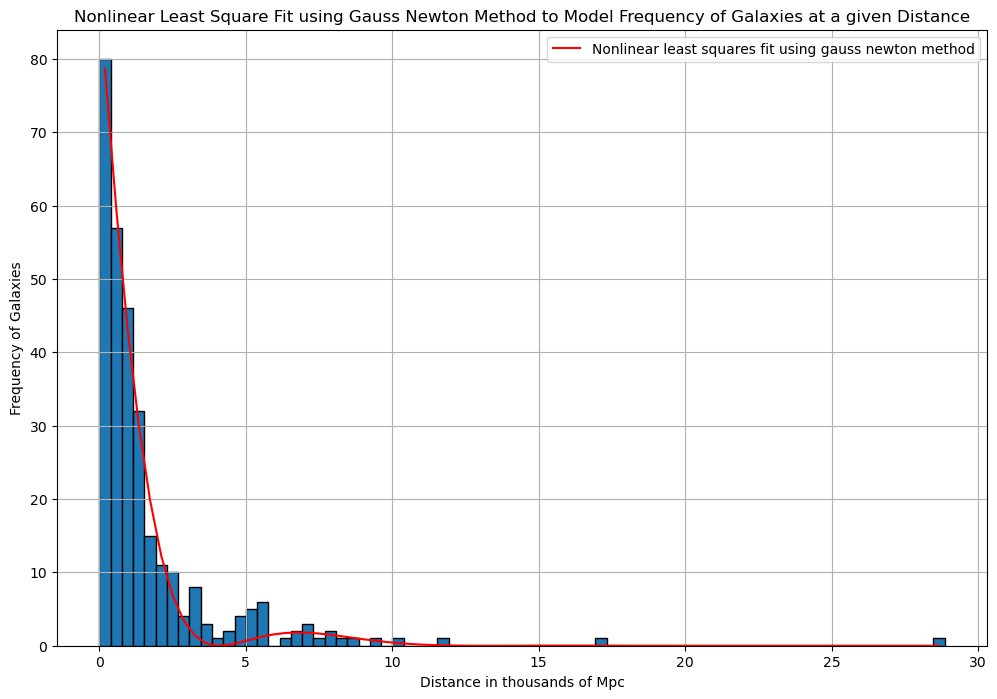

a = 91.55028413909112, b = 0.5128126291670112, c = 0.3443967136213998, d = 3.303051862182491


In [40]:
function = model_function   #This creates an instance of the model function


a_final, b_final, c_final, d_final = gauss_newton_method(x_values, y_values, 90, .2,.37, 4, 100, .00001, function)     #Extracts the parameters that have been minimized for the dataset
fitted_vals = model_function(a_final, b_final, c_final, d_final, x_values)                                       #Creates an array of y values using the minimized parameters substituted into the function for each x value

#Plotting
plt.figure(figsize = (12,8))
plt.hist(data['Distance (Mpc)'], bins = 75, edgecolor = 'black')  
#plt.scatter(x_values, y_values, label = "Frequencies", color = "green") <-- this is to show the midpoints on a scatter plot
plt.plot(x_values, fitted_vals, label = 'Nonlinear least squares fit using gauss newton method', color = 'red')
plt.title("Nonlinear Least Square Fit using Gauss Newton Method to Model Frequency of Galaxies at a given Distance")
plt.xlabel("Distance in thousands of Mpc")
plt.ylabel("Frequency of Galaxies")
plt.legend()
plt.grid(True)
plt.show()
print(f'a = {a_final}, b = {b_final}, c = {c_final}, d = {d_final}')


Given the plot above the fit looks great for the first part of the graph however we see that it isnt very accurate in modeling the humps. I find that the graph seems to be a little bit underfit due to not necessarily the method being wrong or choosing an incorrect model function but the way that I collect the data. Essentially what I mean by this is that when graphing the midpoints alone we see that we only get about 75 points since that is how many bins we have, which I believe is to be too little of data to fit a complex curve, such as the one we have here hence it underfits. To simply put it into perspective, below I graphed the histogram without the bars so we can better see the individual points (not many).

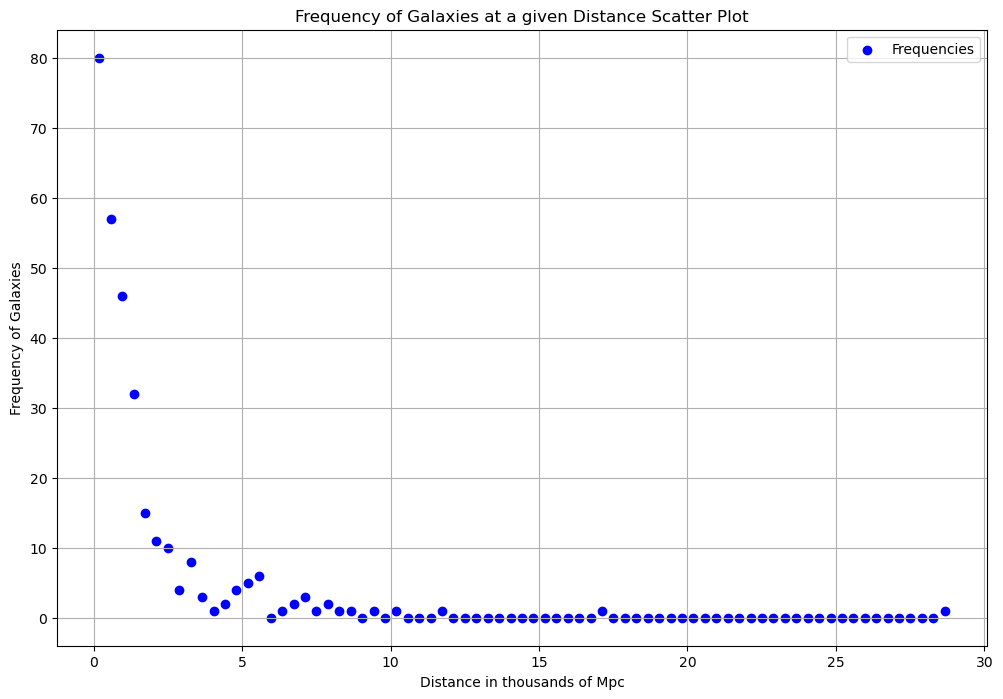

In [41]:
plt.figure(figsize = (12,8))  
plt.scatter(x_values, y_values, label = "Frequencies", color = "blue") 
plt.title("Frequency of Galaxies at a given Distance Scatter Plot")
plt.xlabel("Distance in thousands of Mpc")
plt.ylabel("Frequency of Galaxies")
plt.legend()
plt.grid(True)
plt.show()


Now we can more clearly see that it isn't easy to produce a perfect fit given the limited dataset. Another way we can try to fit the curve is through overfitting which brings me to my second way of fitting which is cubic spline interpolation. I believe overfitting the values through cubic spline interpolation can better represent our given dataset here.
<br><br><br>

Cubic spline interpolation is essentially a technique that uses a cubic function between two points to approximate and produce a smooth curve between them with the condition that the first and second derivatives remain continuous. This essentially means that the functions have well behaved derivatives and hence can be numerically integrated and differentiated. The method then takes the next set of points to produce another curve between the new points all the while remaining continuous with the previous functions curve. This is then repeated for the rest of the dataset essentially there is a cubic function between any two consecutive points. In the end the interpolating function given $N$ points over $n = N - 1$ intervals can be represented as: $$f(x) = \begin{cases} g_{1}(x)  & x_1 < x < x_2 \\ \vdots \\ g_{n}(x) & x_{n} < x < x_{n+1}\end{cases} $$ Where the function $g_i(x)$ can be defined as: $g_i(x) = a_i + b_i(x-x_i) + c_i(x-x_i)^2 + d_i(x-x_i)^3$.

<br><br>
A tad bit more insight, the reason here we use cubic spline interpolation as to quadratic or linear interpolation methods is because it would represent the data much better since the method provides more freedom to fit between each point. For example linear interpolation only fits a straight line between the data and quadratic is only a parabola. What makes cubic spline interpolation truly unique is the derivative conditions stated above which make it smooth, which the former two do not satisfy.
<br><br>

To implement this we must first find out coefficients for each function given the boundary conditions being $x_i$ to $x_{i+1}$. To conceptually solve for them we can see that we will have $n$ equations of $g(x)$ and each equation of $g(x)$ has 4 unknowns. This corresponds to us solving for $4n$ unknowns. We know that the fit is continuous at all of our given points $g_i(x_i) = y_i$ and $g_i(x_{i+1}) = y_{i+1} = g_{i+1}(x_{i+1})$ and  $g_{i+1}(x_{i+2}) = y_{i+2}$. This corresponds to giving us $2n$ equations. We also want the first derivative to be continuous at the endpoints leading onto the next spline hence we get $g_{i}^\prime (x_{i}) = g_{i+1}^\prime(x_{i})$ giving us another $n-1$ equations. We also wanted the second derivative to be continuous hence we get $g_{i}^{\prime\prime}(x_{i}) = g_{i+1}^{\prime\prime}(x_{i})$ giving us another $n-1$ equations. Adding all the equations up we get $4n-2$ hence we can use the arbitrary conditions for the natural cubic spline interpolation method that the boundary's second derivative is equal to zero hence we get $g_{1}''(x_1) = 0$ and $g_{n}''(x_{n+1}) = 0$ finally giving us $4n$ equations to solve. Using these systems of equations and a matrix we can solve for the coefficients of each $g(x)$.

<br><br>
Following from Phys 115 - Lecture 13, we can use a handy tool from the scipy library that calculates all the coefficients for us. This uses the scipy library to import a CubicSpline method which calculates the coefficients and allows us to create the fit for our dataset. We can began to do this by first importing CubicSpline from the scipy.interpolate library. 


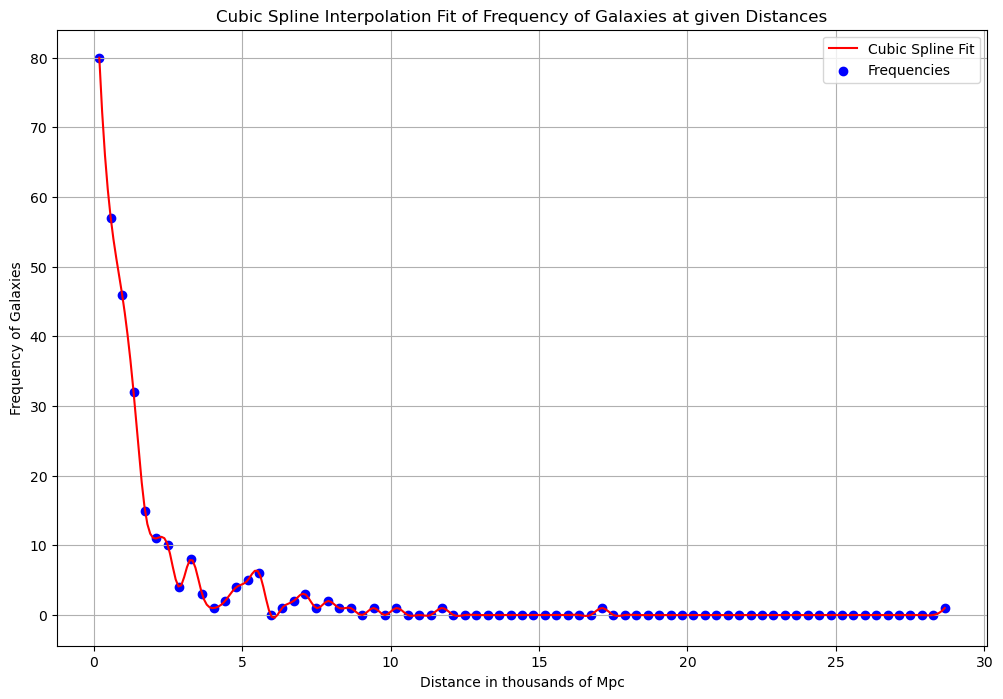

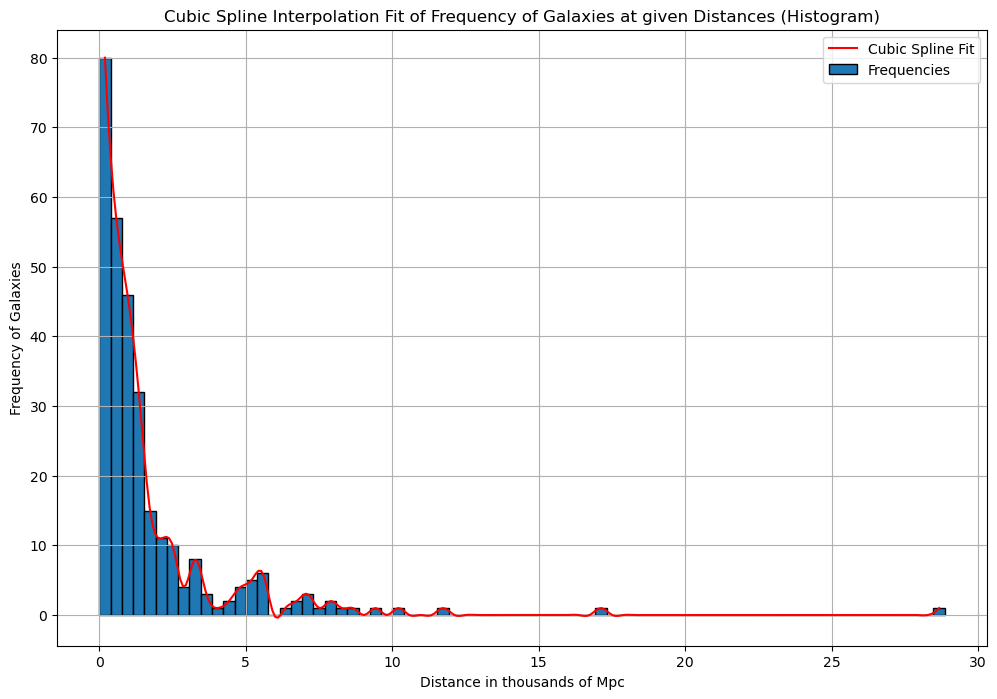

In [42]:
from scipy.interpolate import CubicSpline                                   #Imports the Cubic Spline Interpolation method (follows from Lecture 13)

spline = CubicSpline(x_values, y_values)                                    #Creates spline function for our values

xs = np.linspace(x_values.min(), x_values.max(), 300)                       #Calculates finer x values evenly spaced throughout the entire interval (this inturn makes the fit look much smoother)        
ys = spline(xs)   #Creates splines for each interval in our data set


#Plotting
plt.figure(figsize=(12,8))
plt.plot(xs, ys, color = 'red', label = 'Cubic Spline Fit')
plt.scatter(x_values, y_values, color = 'blue', label = 'Frequencies')
plt.title("Cubic Spline Interpolation Fit of Frequency of Galaxies at given Distances")
plt.xlabel("Distance in thousands of Mpc")
plt.ylabel("Frequency of Galaxies")
plt.legend()
plt.grid(True)
plt.show()

#Same plot but visualized with a histogram rather than just the midpoints
plt.figure(figsize=(12,8))
plt.plot(xs, ys, color = 'red', label = 'Cubic Spline Fit')
plt.hist(data['Distance (Mpc)'], bins = 75, edgecolor = 'black', label = 'Frequencies')  
plt.title("Cubic Spline Interpolation Fit of Frequency of Galaxies at given Distances (Histogram)")
plt.xlabel("Distance in thousands of Mpc")
plt.ylabel("Frequency of Galaxies")
plt.legend()
plt.grid(True)
plt.show()


We can see above that the fit using cubic spline interpolation seems to much better represent our dataset. I believe that this is obviously due to the overfitting done by the method hence it is able to represent all given data points well. The downside to this method is if I were to introduce new data points the fit would skew a bit hence change its look whereas I believe that the fit using non linear least squares wouldnt change very drastically due to the expectation weights. Next as extra I wanted try to see how the dataset would be fit by a much more complex method such as something that the machine learning library Scikit-Learn uses. Below I will try to fit the data using the Scikit-Learn library and hope to see where I can improve in the future.

<br><br>

To start off the polynomial regression model we can begin by importing Linear Regression and Polynomial features from Scikit-Learn. Polynomial regression essentially fits an nth degree polynomial given our dataset through finding the valid coefficients through using algebraic methods to optimize the error, analogous to how coefficients were found using least mean squares using Gauss Newton method to optimize above. Next we must reshape the data into a 2-D array so that the library is able to process it correctly. My work here is referenced from my own personal project which I will have linked below.

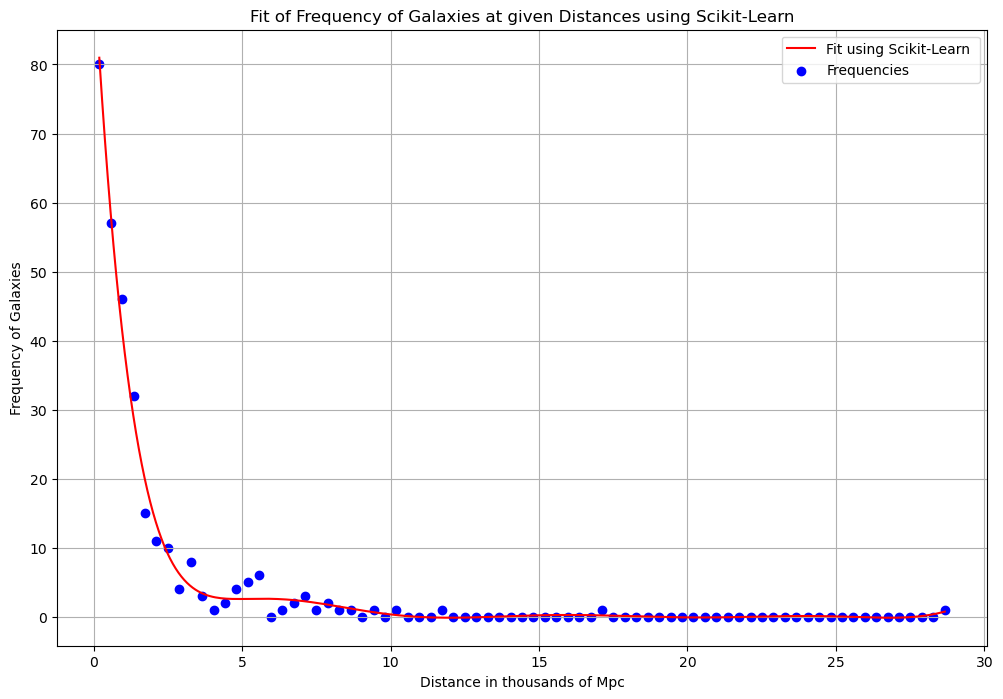

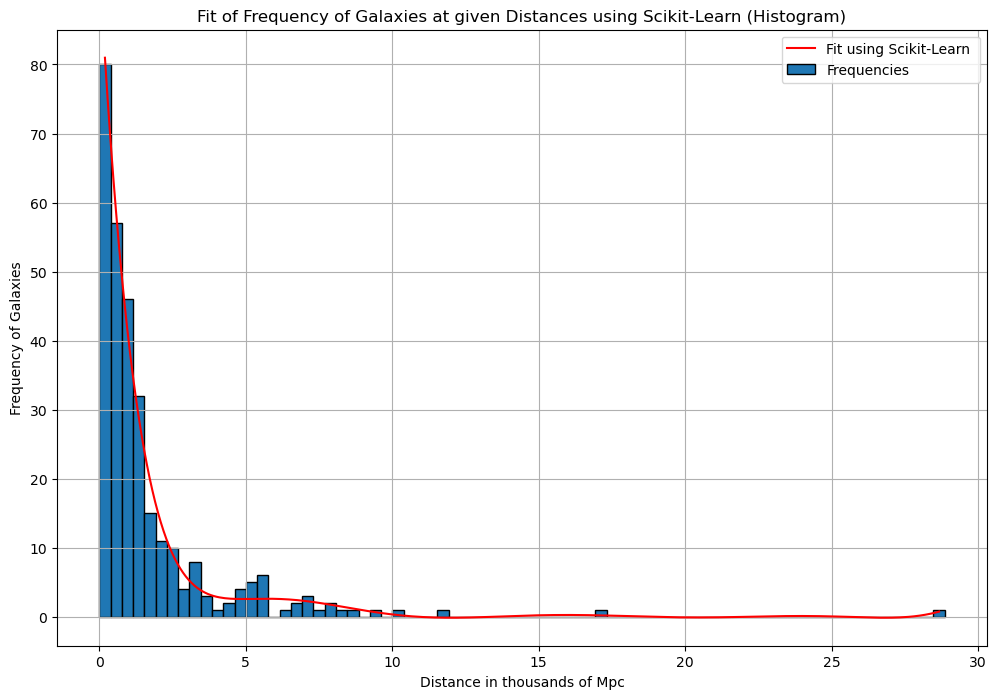

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
#The code above imports the necessary libraries

X = x_values.reshape(-1, 1)                     #Reshapes the data into a 2D array as needed
Y = y_values

deg = 9                                                         #This is the polynomial degree, the more higher it goes the more the curve will tend to overfit the data

polyfit = PolynomialFeatures(degree = deg, include_bias= False) #This line creates the polynomial features
x_polyfit = polyfit.fit_transform(X)                            #This line rewrites the x input array with the given polynomial features

model = LinearRegression() #Initialzies the model itself
model.fit(x_polyfit, Y)    #Fits the model with our given features 

xs2 = np.linspace(X.min(), X.max(), 300).reshape(-1,1) #Just as done in the cubic spline interpolation this makes the x points finer (then reshapes to be read by Scikit) to fit the data so the fit looks more smooth
y_fit = model.predict(polyfit.transform(xs2)) #Predicts the Y values using the fit polynomial given the fine x points


#Plotting
plt.figure(figsize=(12,8))
plt.plot(xs2, y_fit, color = 'red', label = 'Fit using Scikit-Learn ')
plt.scatter(x_values, y_values, color = 'blue', label = 'Frequencies')
plt.title("Fit of Frequency of Galaxies at given Distances using Scikit-Learn")
plt.xlabel("Distance in thousands of Mpc")
plt.ylabel("Frequency of Galaxies")
plt.legend()
plt.grid(True)
plt.show()

#Same plot as above but with the histogram bins
plt.figure(figsize=(12,8))
plt.plot(xs2, y_fit, color = 'red', label = 'Fit using Scikit-Learn ')
plt.hist(data['Distance (Mpc)'], bins = 75, edgecolor = 'black', label = 'Frequencies')  
plt.title("Fit of Frequency of Galaxies at given Distances using Scikit-Learn (Histogram)")
plt.xlabel("Distance in thousands of Mpc")
plt.ylabel("Frequency of Galaxies")
plt.legend()
plt.grid(True)
plt.show()




Looking at this fit I would say it definitely represents the nonlinear least square fit much more than it does the cubic spline interpolation. I believe this is due to the fact that we use polynomial regression here rather than other fitting methods (which may tend to better overfit the data). What this tells me is that our Gauss Newton method was actually quite efficient in this case as it seems to resemble the polynomial regression fit done by Scikit all though Scikit seems to be able to detect the smaller humps near the 17000 Mpc and 28000 Mpc mark whereas the nonlinear least square fit doesn't which is something that can definitely be improved on in the future either by choosing an even more complex function or changing up the optimization method from Gauss Newton to something else.

<br><br><br><br>

<br><br><br><br><br><br><br><br>
References:
<br><br>
Measuring the Hubble constant with kilonovae using the expanding photosphere method
Albert  Sneppen, Darach  Watson, Dovi  Poznanski, Oliver  Just, Andreas  Bauswein, Radosław  Wojtak
A&A 678 A14 (2023)
DOI: 10.1051/0004-6361/202346306
(https://www.aanda.org/articles/aa/full_html/2023/10/aa46306-23/aa46306-23.html)
<br><br>
My personal regression model project: https://github.com/karth2k/home-prices-regression-model/tree/main
<br><br>
Phys 115 - Lecture 11 (For the uncertainty and some insight on fitting)
<br><br>
Phys 115 - Lecture 13 (To perform spline interpolation and how to solve for constants)
<br><br>
The gauß-newton method and its implementation in the ... (n.d.). https://kops.uni-konstanz.de/server/api/core/bitstreams/cd12a2ac-f826-4564-b2b0-5c0a63c48dd6/content 

